I'm starting again from scratch. Jason Brownlee has a more suitable tutorial for me to base this work on. It's here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

He's using a 2D dataset, not a 3D one. I haven't come across a 3D one yet.


In [6]:
from math import sqrt
import numpy
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Masking
 

Using TensorFlow backend.


JB uses a different dataset, but let's try his data format tool for NHL data.

Let's keep in mind that this function takes in an array and outputs a dataframe.


In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Let's load the NHL data.

Then, grab a few guys stats. Extract from the stats dataframe. Alex Ovechkin, whose player id is 8471214, Matt Duchene (8471707), Pat Maroon (8474034), and The Tank (8475765).

In [8]:
# load the data
statspd=read_csv('s_skater_summary.csv')#,header=None)

# isolate only stats for our players of interest
SKATERstats = statspd[statspd['playerId'].isin([8471214, 8471707, 8474034, 8475765])]

# prepare to remove some data for now
print(SKATERstats.columns)

Index(['assists', 'faceoffWinPctg', 'gameWinningGoals', 'gamesPlayed', 'goals',
       'otGoals', 'penaltyMinutes', 'playerFirstName', 'playerId',
       'playerLastName', 'playerName', 'playerPositionCode',
       'playerTeamsPlayedFor', 'plusMinus', 'points', 'pointsPerGame',
       'ppGoals', 'ppPoints', 'seasonId', 'shGoals', 'shPoints',
       'shiftsPerGame', 'shootingPctg', 'shots', 'timeOnIcePerGame'],
      dtype='object')


In [9]:
# I kept those stats that had the strongest correlation to Goals, as determined in the
# Basic_stats_analysis notebook: Goals, Assists, PPPoints, SHT%, Shots. I also kept Games Played

SKATERstats.drop(['faceoffWinPctg', 'gameWinningGoals',
       'otGoals', 'penaltyMinutes', 'playerFirstName',
       'playerLastName', 'playerName', 'playerPositionCode',
       'playerTeamsPlayedFor', 'plusMinus', 'points', 'pointsPerGame',
       'ppGoals', 'shGoals', 'shPoints',
       'shiftsPerGame', 'timeOnIcePerGame'], axis=1, inplace=True)

/Users/Galloway/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Before we continue, rearrange the columns so that the stat we'd like to predict is the last column (goals in our case). This follows the convention found in the flow this notebook is based on.


In [10]:
cols = list(SKATERstats.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('goals')) #Remove Goals from list
SKATERstats = SKATERstats[cols+['goals']] #Create new dataframe with columns in the order you want

SKATERstats

,assists,gamesPlayed,playerId,ppPoints,seasonId,shootingPctg,shots,goals
1,36,82,8475765,22,20162017,0.1363,286,39
9,15,81,8474034,6,20162017,0.1516,178,27
15,18,70,8471707,13,20162017,0.1138,202,23
862,36,82,8471214,26,20162017,0.1054,313,33
910,21,79,8471214,24,20152016,0.1256,398,50
956,27,82,8471707,14,20152016,0.1156,268,31
1137,34,80,8475765,24,20152016,0.1369,292,40
1763,15,72,8474034,8,20152016,0.1153,104,12
2277,25,71,8474034,7,20142015,0.0750,120,9
2464,36,77,8475765,18,20142015,0.1401,264,37


We'll also scale the data now:

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1)) # JB used -1,1 when data was stationary
scaler = scaler.fit(SKATERstats.values)

# Convert this dataframe to an array and scale:
SKATERscaled = scaler.transform(SKATERstats.values)

# to unscale, we'll use:
# inverted = scaler.inverse_transform(array)

The next cell is from JB's code. I don't think it's necessary for me.

Before we transform the data, we'll need to sort the data into 3D. The transform should probably be applied within the sorting algorithm.

In [12]:
def sortforML_scale_supervised(df ,scaler):
    # Input a dataframe, get back a numpy array.
    
    # This algorithm assumes the dataframe is already sorted by year (latest first).
    # Also, make sure the dataframe has the stat you desire to predict as the last column.
    
    # Sometimes the column names present difficulties for indexing.
    
    # To match JB's example, the data should exist as (sample,timestep,features).
    # Wait a second... he uses all the time sampels as samples, not timesteps. I'll just do what he does!
    
    # Create a zero array the size that we want
    out = numpy.zeros((len(df.seasonId.unique()), len(df.playerId.unique()), len(df.columns)+1))
    
    # Make empty values -1 instead of 0
    out -=1
    
    # Loop through all players in the dataset. Place their stats into a unique layer in the output array.
    for i, player in enumerate(df.playerId.unique()):
        # Populate a layer in the output array.
        
        # Aside... I'm torn on whether ensure consistency in the position of the years in the output array.
        # i.e. Should 20122013 always be found in the same row, regardless of the player? Retired players wouldn't
        # have stats for the latest years, so to do this, one would have to shift the data down a number of rows
        # within their layer. This would create a pad of zeros at the top of their stats though... problem?
        # I'll move ahead with the simpler operation: first row of all layers will be the player's latest season.
        # If seasonId is included in the stats, the ML algorithm will have access to the year. Maybe that's enough.
        
        popped = df.loc[df['playerId'] == player].values
        
        # apply scaler
        popscaled = scaler.transform(popped)
        
        # transform to supervised (takes array and returns df - this enables the next step...)
        poptrans = series_to_supervised(popscaled, 1, 1)
        # remove all new columns except the new un-lagged one that we're trying to predict
        poptrans.drop(poptrans.columns[[8,9,10,11,12,13,14]], axis=1, inplace=True)
        poptrans = poptrans.values
        
        out[:len(poptrans),i,:]=poptrans
        
    return out

Let's apply the function that transforms the data:

In [13]:
Sstats3D = sortforML_scale_supervised(SKATERstats, scaler)


I will split the data into training and test data. Let's say the latest two seasons are the test!

In [14]:
# split into train and test sets
train = Sstats3D[2:, :, :]
test = Sstats3D[:2, :, :]
# split into input and outputs
train_X, train_y = train[:, :, :-1], train[:, :, -1]
test_X, test_y = test[:, :, :-1], test[:, :, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10, 4, 8) (10, 4) (2, 4, 8) (2, 4)


Designing a network

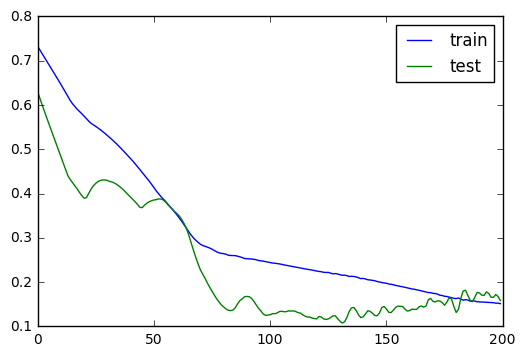

In [15]:
# design network
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50))
model.add(Dense(4))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Make a prediction and evaluate the performance

In [16]:
# make a prediction
yhat = model.predict(test_X)

# make yhat dimension match test_X
yhat = numpy.expand_dims(yhat,axis=2)

# invert scaling for forecast
inv_yhat = numpy.concatenate((test_X[:,:,:-1],yhat), axis=2)
for i in range(inv_yhat.shape[1]):
    inv_yhat[:,i,:] = scaler.inverse_transform(inv_yhat[:,i,:])
inv_yhat = inv_yhat[:,:,-1]

# invert scaling for actual

# make y dimension match test_X
test_y = numpy.expand_dims(test_y,axis=2)

#test_y = test_y.reshape((len(test_y), 1))
inv_y = numpy.concatenate((test_X[:, :, :-1],test_y), axis=2)
for i in range(inv_y.shape[1]):
    inv_y[:,i,:] = scaler.inverse_transform(inv_y[:,i,:])
inv_y = inv_y[:,:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.998


Let's see how we did for these fellas in particular.

In [19]:
for i in range(inv_yhat.shape[1]):
    print('Player %s, year 1 (predicted,actual) = ( %s , %s )' % (i, int(inv_yhat[0,i]),int(inv_y[0,i])))
    print('Player %s, year 2 (predicted,actual) = ( %s , %s )' % (i, int(inv_yhat[1,i]),int(inv_y[1,i])))

Player 0, year 1 (predicted,actual) = ( 27 , 40 )
Player 0, year 2 (predicted,actual) = ( 25 , 36 )
Player 1, year 1 (predicted,actual) = ( 24 , 12 )
Player 1, year 2 (predicted,actual) = ( 15 , 9 )
Player 2, year 1 (predicted,actual) = ( 44 , 31 )
Player 2, year 2 (predicted,actual) = ( 38 , 23 )
Player 3, year 1 (predicted,actual) = ( 44 , 50 )
Player 3, year 2 (predicted,actual) = ( 48 , 52 )
